In [70]:
#! pip install lightgbm
#! pip install xgboost
#! pip install pycaret
#! pip install graphviz
#! conda install graphviz --yes
#! pip install pydotplus
#! python -c "import graphviz"
#! conda install graphviz python-graphviz --use-local --yes
#! pip install dtreeviz


     |████████████████████████████████| 60 kB 326 kB/s eta 0:00:011
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66638 sha256=2dad7e6fac9cdf5466514397f7ad8f0d1569e436dc89595cd22c85323273c1c4
  Stored in directory: /home/princeba/.cache/pip/wheels/9e/37/2c/3b30269ca762b6bb992fd0abb640f3e384c290e719597fddbc
Successfully built dtreeviz


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
import xgboost as xgb

import lightgbm as lgb
import pickle

from pycaret.classification import *
import base64
import graphviz
from dtreeviz.trees import *
#import python-graphviz
import lightgbm as lgb


# Implémentez un modèle de scoring

In [73]:
%reset -f

## Contexte
La société financière __Prêt à penser__ propose des crédits à la consommation aux personnes ayant peu d'historique de crédit. Aujourd'hui elle souhaite développer un modèle de scoring pour les aider à décider à accorder un prêt ou non à leur futur client. <br>
Aussi souhaite-t-elle développer en parallèle un dashboard qui permettra à leur collaborateur d'expliquer aux clients les raisons de leur choix. Ces derniers sont de plus en plus demandeur de transparence.

## Jeu de données
__Prêt à penser__ nous a mis à disposition un ensemble de jeu de données qui relatent des faits financières de plusieurs clients (montant des crédits précédents, leur nombre, leur état (en cours, défaut, completé etc) et des données indirectes (sex du client, conjoint, nombre d'enfants etc)

## Enjeux
À partir de ces données, nous allons développer un modèle classification qui sera mis en perspective à l'aide d'un dashboard qui permettra aux chargés de relation client d'expliquer aux clients les décisions émises quant à leur besoin de crédit.

## Table des matières

* [Chargement des données](#chap1)
* [Définition des fonctions](#chap2)
* [Nettoyages des données et feature engineering](#chap3)

    * [Section 1.1](#section_1_1)
    * [Section 1.2](sSection_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)

# Chargement des données <a class="anchor" id="chap1"></a>

In [2]:

# appTrain = pd.read_csv("zip/application_train.csv")
# bureau = pd.read_csv("zip/bureau.csv")
# bureauBal = pd.read_csv("zip/bureau_balance.csv")
# creditCardBal = pd.read_csv("zip/credit_card_balance.csv")
# homeCredit = pd.read_csv("zip/HomeCredit_columns_description.csv")
# installmentsP = pd.read_csv("zip/installments_payments.csv")
# POS_CASH_B = pd.read_csv("zip/POS_CASH_balance.csv")
# previous_Apps = pd.read_csv("zip/previous_application.csv")
# sample_sub = pd.read_csv("zip/sample_submission.csv")

In [4]:
#previous_Apps

# Définition des fonctions <a class="anchor" id="chap2"></a>

In [3]:
# Reduire la taille des données
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe avant traitement {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Taille du Dataframe après traitement: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def Description(Status=""):
    dire = homeCredit.loc[homeCredit["Row"]==Status,]["Description"]
    print(dire.values)
    return dire

In [5]:
def colNul(df, nulle = 0):
    print(df.loc[:,(df.isna().sum() == nulle).values])
    return list(df.loc[:,(df.isna().sum() == nulle).values].columns)

In [6]:
def extraireColonneInf(df, pourcentage = 1):
    
    save = (df.notna().sum(axis=0)/df.shape[0])
    save = save[save <= pourcentage]
    return list(save.index)

In [7]:
def aggregation(data, drop = [], groupby='', col='data', agg=['count', 'mean', 'median', 'max', 'min', 'sum']):
    modelisation = data.drop(drop, axis=1)
    model_num = modelisation.select_dtypes(exclude=['object', 'category'])
    model_cat = modelisation.select_dtypes(include=['object', 'category'])
    #print(model_cat)
    #print(model_cat.shape)
    
    if model_cat.shape[1]!=0:
        
        model_onhot = pd.get_dummies(model_cat, drop_first=True)
        data_agg = pd.concat([data[groupby],model_num, model_onhot], axis=1)
        
    else:
        data_agg = pd.concat([data[groupby],model_num], axis=1)
        
    data_agg = data_agg.groupby(groupby, as_index = False).agg(agg).reset_index()
    
    columns = [groupby]

    for var in data_agg.columns.levels[0]:
        if var != groupby:

            for stat in data_agg.columns.levels[1][:-1]:

                columns.append(col+'_%s_%s' % (var, stat))

    data_agg.columns = columns
    data_agg.head()

    
    return data_agg

# Nettoyages des données et feature engineering <a class="anchor" id="chap3"></a>

In [8]:

appTrain = reduce_mem_usage(pd.read_csv("zip/application_train.csv"))
# bureau = reduce_mem_usage(pd.read_csv("zip/bureau.csv")) 
# bureauBal = reduce_mem_usage(bureauBal) 
# creditCardBal = reduce_mem_usage(creditCardBal) 
# homeCredit = reduce_mem_usage(homeCredit) 
# installmentsP = reduce_mem_usage(installmentsP) 
# POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
# previous_Apps = reduce_mem_usage(previous_Apps) 
# sample_sub = reduce_mem_usage(sample_sub) 

Taille du Dataframe avant traitement 286.23 MB
Taille du Dataframe après traitement: 59.54 MB
Réduction de 79.2%


Nous réduisons la taille du jeu de données dans la mémoire.

In [11]:
# Train_num = appTrain.select_dtypes(exclude=['category'])
# Train_cat = appTrain.select_dtypes(include=['category'])

In [12]:
appTrain.shape

(307511, 122)

In [13]:
test = (appTrain.notna().sum(axis=0)/appTrain.shape[0])
list(test[test <=0.8].index)

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

In [14]:
appTrain['AMT_REQ_CREDIT_BUREAU_DAY'].describe()

count    265992.000000
mean          0.007000
std           0.110718
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

In [15]:
colonne = extraireColonneInf(appTrain,0.8)

In [16]:
appTrainC = appTrain.drop(extraireColonneInf(appTrain,0.8), axis=1).copy()

In [17]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,N

On supprime les colonnes qui ont plus de 20% de NAN

In [18]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('AMT_REQ')], axis=1, inplace=True)

In [19]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('APPR')], axis=1, inplace=True)

In [20]:
appTrainC

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.262939,0.139404,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,0,0,0,0,0,0,School,0.622070,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,0,0,0,0,0,0,Government,0.556152,0.729492,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008018,-19005,-3039,-9832.0,-2437,1,1,0,1,0,0,2.0,2,2,0,0,0,0,0,0,Business Entity Type 3,0.650391,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028656,-19932,-3038,-4312.0,-3458,1,1,0,1,0,0,1.0,2,2,0,0,0,0,1,1,Religion,0.322754,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032562,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,0,0,0,0,0,0,Services,0.681641,NaN,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025162,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,0,0,0,0,0,0,XNA,0.115967,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005001,-14966,-7921,-6736.0,-5150,1,1,0,1,0,1,1.0,3,3,0,0,0,0,1,1,School,0.535645,0.218872,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005314,-11961,-4786,

In [21]:
test = Description('LIVE_CITY_NOT_WORK_CITY')

['Flag if client's contact address does not mat...]
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


In [22]:
test[test.index.values[0]]

"Flag if client's contact address does not match work address (1=different, 0=same, at city level)"

In [23]:
appTrainC.columns[appTrainC.columns.str.contains('NOT')]

Index(['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'],
      dtype='object')

In [24]:
appTrainC['LIVE_REGION_NOT_WORK_REGION'].describe()

count    307511.000000
mean          0.040659
std           0.197499
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

In [25]:
appTrainC.drop(appTrainC.columns[appTrainC.columns.str.contains('NOT')], axis=1, inplace=True)

In [26]:
#Description('NAME_TYPE_SUITE')

In [27]:
colonne = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 
           'REGION_RATING_CLIENT', 'NAME_TYPE_SUITE', 'DAYS_LAST_PHONE_CHANGE',
          'DAYS_LAST_PHONE_CHANGE']

In [28]:
appTrainC.drop(colonne, axis=1, inplace=True)

In [29]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [30]:
test = Description('ORGANIZATION_TYPE')

['Type of organization where client works']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


In [31]:
test[test.index.values[0]]

'Type of organization where client works'

In [32]:
#appTrainC.drop('NAME_TYPE_SUITE', axis=1, inplace=True)
#appTrainC.drop(['DAYS_LAST_PHONE_CHANGE'], axis=1, inplace=True)

In [33]:
#appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].sum(axis=1).describe()

In [34]:
#appTrainC.drop(list(appTrainC.loc[:,'FLAG_DOCUMENT_2': 'FLAG_DOCUMENT_21'].columns), axis=1, inplace=True)

La variation des variables FLAG_DOCUMENT est faible. Nous allons les supprimer

In [35]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [36]:
appTrainC.columns[appTrainC.columns.str.contains('FLAG')]

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [37]:
appTrainC['EXT_SOURCE_3'].describe()

count    246546.000000
mean               NaN
std           0.000000
min           0.000527
25%           0.370605
50%           0.535156
75%           0.668945
max           0.895996
Name: EXT_SOURCE_3, dtype: float64

In [38]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_3'].notna(),'EXT_SOURCE_3'].astype(np.float32).mean()

In [39]:
appTrainC['EXT_SOURCE_3'].fillna(valeur, inplace=True)

In [40]:
valeur = appTrainC.loc[appTrainC['EXT_SOURCE_2'].notna(),'EXT_SOURCE_2'].astype(np.float32).mean()

In [41]:
appTrainC['EXT_SOURCE_2'].fillna(valeur, inplace=True)

In [42]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307511 non-null  int32   
 1   TARGET                      307511 non-null  int8    
 2   NAME_CONTRACT_TYPE          307511 non-null  category
 3   CODE_GENDER                 307511 non-null  category
 4   FLAG_OWN_CAR                307511 non-null  category
 5   FLAG_OWN_REALTY             307511 non-null  category
 6   CNT_CHILDREN                307511 non-null  int8    
 7   AMT_INCOME_TOTAL            307511 non-null  float32 
 8   AMT_CREDIT                  307511 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307233 non-null  float32 
 11  NAME_INCOME_TYPE            307511 non-null  category
 12  NAME_EDUCATION_TYPE         307511 non-null  category
 13 

In [43]:
#appTrainC['AMT_ANNUITY'].fillna(appTrainC['AMT_ANNUITY'].mean(), inplace=True)
appTrainC = appTrainC[appTrainC["AMT_ANNUITY"].notna()]

In [44]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307221 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [45]:
appTrainC.drop(list(appTrainC.columns[appTrainC.columns.str.contains('SOCIAL')]), axis=1, inplace=True)

In [46]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307221 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [47]:
#appTrainC['AMT_GOODS_PRICE'].mean()
appTrainC.loc[appTrain['AMT_GOODS_PRICE'].isna(), 'AMT_GOODS_PRICE'] = appTrain.loc[appTrain['AMT_GOODS_PRICE'].isna(),"AMT_CREDIT"]

In [48]:
appTrainC['CNT_FAM_MEMBERS'].fillna(appTrainC['CNT_FAM_MEMBERS'].astype(np.float32).mean(), inplace=True)

In [49]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307499 non-null  int32   
 1   TARGET                      307499 non-null  int8    
 2   NAME_CONTRACT_TYPE          307499 non-null  category
 3   CODE_GENDER                 307499 non-null  category
 4   FLAG_OWN_CAR                307499 non-null  category
 5   FLAG_OWN_REALTY             307499 non-null  category
 6   CNT_CHILDREN                307499 non-null  int8    
 7   AMT_INCOME_TOTAL            307499 non-null  float32 
 8   AMT_CREDIT                  307499 non-null  float32 
 9   AMT_ANNUITY                 307499 non-null  float32 
 10  AMT_GOODS_PRICE             307499 non-null  float32 
 11  NAME_INCOME_TYPE            307499 non-null  category
 12  NAME_EDUCATION_TYPE         307499 non-null  category
 13 

In [50]:
appTrainC.loc[appTrainC["DAYS_EMPLOYED"]==365243, "DAYS_EMPLOYED"] = appTrainC.loc[appTrainC["DAYS_EMPLOYED"]!=365243, "DAYS_EMPLOYED"].mean()

365243 = XNA = NAN donc nous les supprimons

In [51]:
# appTrainC["AMT_INCOME_TOTAL"].describe()

In [52]:
# appTrainC = appTrainC[appTrainC["AMT_INCOME_TOTAL"] < appTrainC["AMT_INCOME_TOTAL"].max()]

Nous supprimons le outlier maximal du feature "AMT_INCOME_TOTAL"

## 2 nouveaux features


In [53]:
appTrainC["credSURrevenu"] = appTrainC["AMT_CREDIT"]/appTrainC["AMT_INCOME_TOTAL"]
appTrainC["annuitySURrevenu"] = appTrainC["AMT_ANNUITY"]/appTrainC["AMT_INCOME_TOTAL"]

Nous avons créé deux nouvelles features pour évaluer combien pèse le crédit sur les révenus du profil aussi bien le crédit total que les mensualités

# Analyse univariée

In [54]:
appTrainC["TARGET"].value_counts()

0    282674
1     24825
Name: TARGET, dtype: int64

In [55]:
appTrainC["TARGET"].value_counts(normalize=True)

0    0.919268
1    0.080732
Name: TARGET, dtype: float64

92% des prêts sont accordés ne débouchent pas sur un défaut de paiement ou dis autrement 8% des prêts font un défaut.

In [56]:
appTrainC["CODE_GENDER"].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [57]:
appTrainC.shape

(307499, 50)

In [58]:
appTrainC = appTrainC[appTrainC["CODE_GENDER"].isin(["F", "M"])]

In [59]:
appTrainC["CODE_GENDER"]=appTrainC["CODE_GENDER"].astype('object')

Nous avons supprimé les profils avec le CODE_GENDER XNA (non communiqué) qui représente 0.000013% des données.
Aussi pouvons nous voir que les profils féminins représentent 66% des données et ceux masculins 34%

In [60]:
appTrainC.groupby(by="CODE_GENDER")["AMT_INCOME_TOTAL"].mean()

CODE_GENDER
F    156030.875000
M    193397.203125
Name: AMT_INCOME_TOTAL, dtype: float32

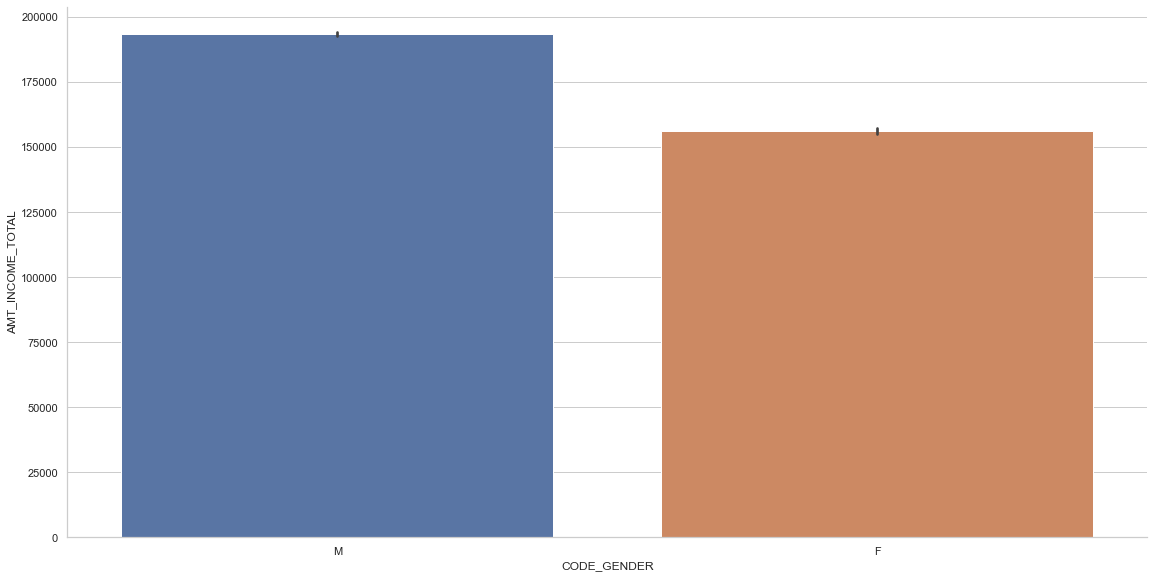

In [61]:

sns.catplot(x="CODE_GENDER", y="AMT_INCOME_TOTAL",kind="bar", height=8, aspect=2, data=appTrainC)


Le revenu des profils masculins est sensiblement plus important que les profils féminins

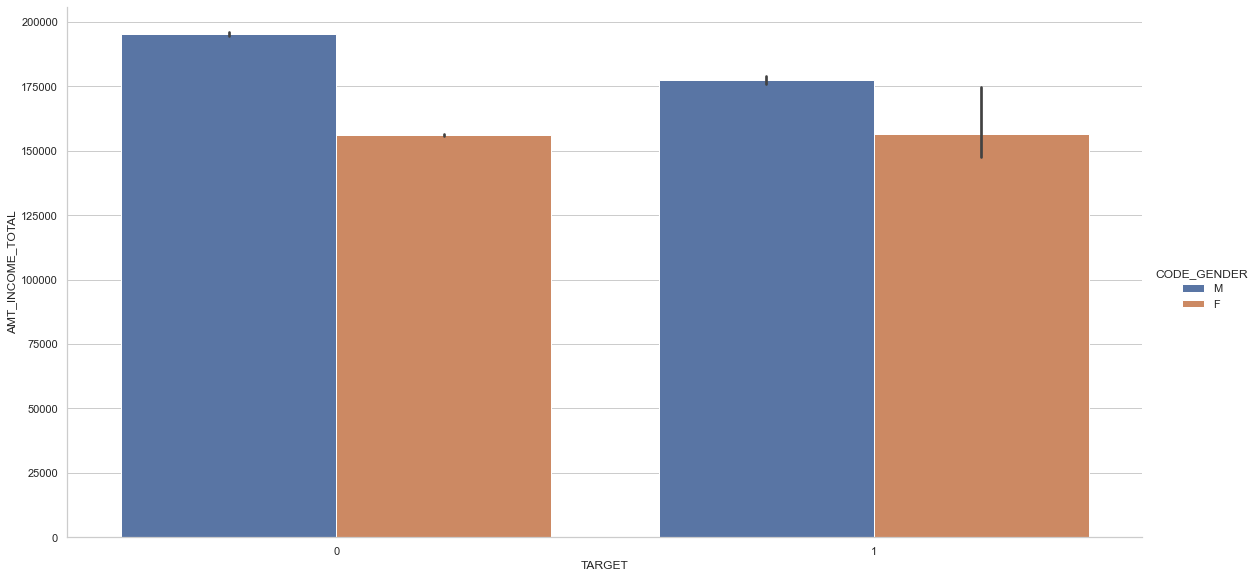

In [62]:
sns.catplot(x="TARGET", y="AMT_INCOME_TOTAL",kind="bar", hue="CODE_GENDER", height=8, aspect=2,data=appTrainC)

Les profils masculins en défaut de paiment gagnent en moyenne moins que les profils qui ne font pas de défaut de paiment. En revanche ce n'est pas le cas pour les profils féminins. Au contraire même. Les profils féminins en défaut de paiment ont des revenus légèrement supérieurs. <br>
Qu'est-ce qui implique alors le défaut de paiment si le salaire n'est pas un facteur important ?

In [63]:
appTrainC[appTrainC["TARGET"]==1]["CODE_GENDER"].value_counts()/appTrainC["CODE_GENDER"].value_counts()

F    0.069996
M    0.101423
Name: CODE_GENDER, dtype: float64

Les profils féminins sont certes plus important au sein du dataset, mais ramener à leur proportion, 7% des profils féminins font un défaut de paiment tandis que les profils masculins en défaut de paiment concernent 10%

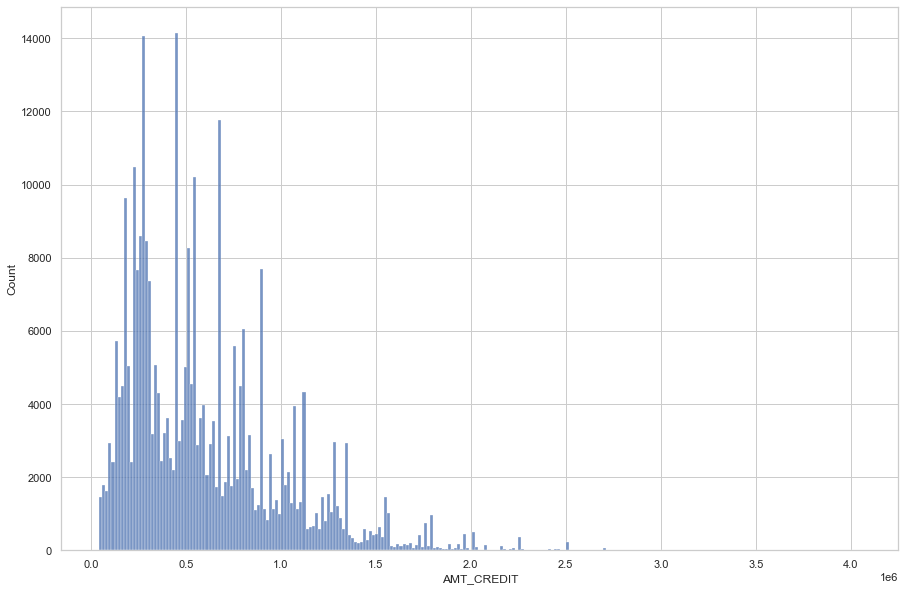

In [64]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrainC, x="AMT_CREDIT")
plt.show()

In [65]:
appTrainC["AMT_CREDIT"].mode()

0    450000.0
dtype: float32

Le mode des crédits est de 450000 (dollars)

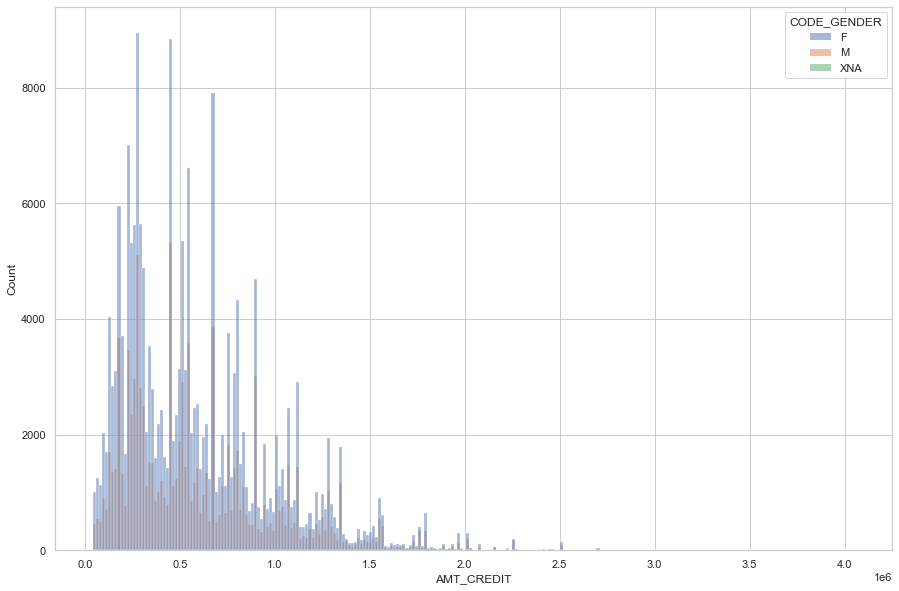

In [66]:
plt.figure(figsize=(15,10))
sns.histplot(data=appTrain, x="AMT_CREDIT", hue='CODE_GENDER')
plt.show()

Les F et M ont le même mode

In [67]:
print(pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True))

TARGET                   0      1     All
NAME_CONTRACT_TYPE                       
Cash loans          254999  23221  278220
Revolving loans      27671   1604   29275
All                 282670  24825  307495


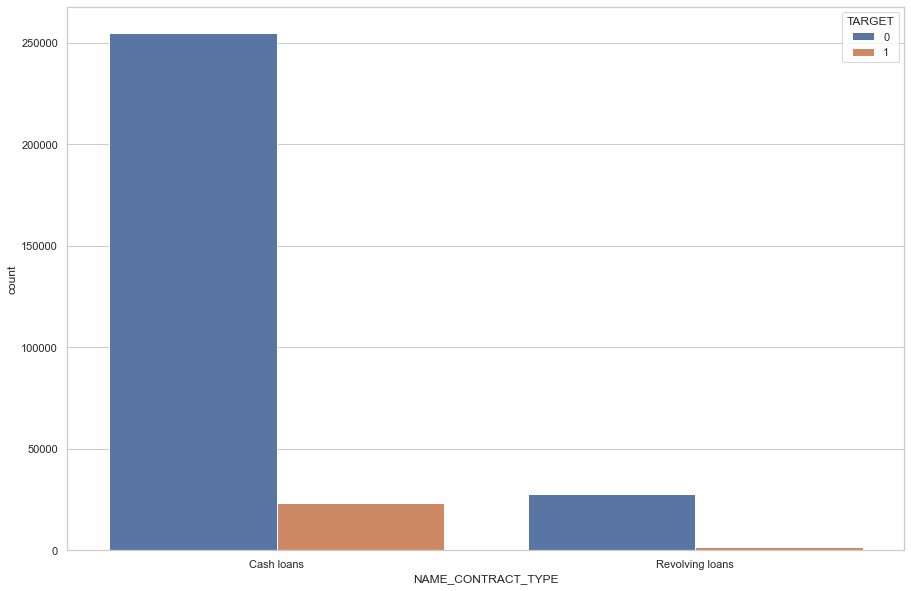

In [68]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=appTrain)

In [69]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]

TARGET
0      254999
1       23221
All    278220
Name: Cash loans, dtype: int64

In [70]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Cash loans"]/278232

TARGET
0      0.916498
1      0.083459
All    0.999957
Name: Cash loans, dtype: float64

In [71]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]

TARGET
0      27671
1       1604
All    29275
Name: Revolving loans, dtype: int64

In [72]:
pd.crosstab(appTrainC['NAME_CONTRACT_TYPE'], appTrainC['TARGET'], margins = True).loc["Revolving loans"]/29275

TARGET
0      0.945209
1      0.054791
All    1.000000
Name: Revolving loans, dtype: float64

Les contrats de type Cash Loans sont de très loin les plus demandés et c'est également sur ces types de contrat (en propotion) qu'il y a le plus de défaut de paiment.

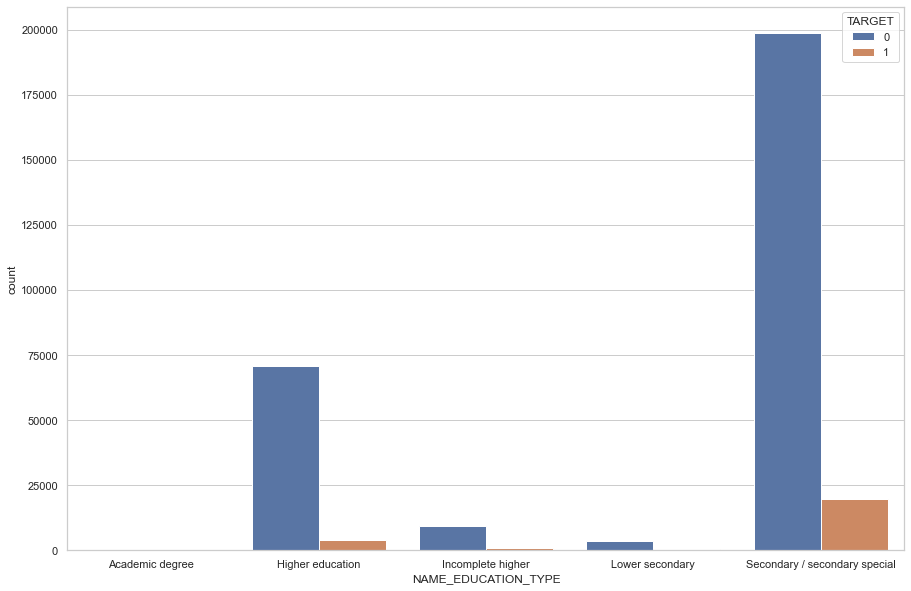

In [73]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=appTrainC)

In [74]:
print(pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True))

TARGET                              0      1     All
NAME_EDUCATION_TYPE                                 
Academic degree                   161      3     164
Higher education                70854   4009   74863
Incomplete higher                9405    872   10277
Lower secondary                  3399    417    3816
Secondary / secondary special  198867  19524  218391
All                            282686  24825  307511


In [75]:
educ = pd.crosstab(appTrain['NAME_EDUCATION_TYPE'], appTrain['TARGET'], margins = True)

In [76]:
educ.iloc[0]/164

TARGET
0      0.981707
1      0.018293
All    1.000000
Name: Academic degree, dtype: float64

In [77]:
educ.iloc[1]/74863

TARGET
0      0.946449
1      0.053551
All    1.000000
Name: Higher education, dtype: float64

In [78]:
educ.iloc[2]/10277

TARGET
0      0.91515
1      0.08485
All    1.00000
Name: Incomplete higher, dtype: float64

In [79]:
educ.iloc[3]/3816

TARGET
0      0.890723
1      0.109277
All    1.000000
Name: Lower secondary, dtype: float64

In [80]:
educ.iloc[4]/218391

TARGET
0      0.910601
1      0.089399
All    1.000000
Name: Secondary / secondary special, dtype: float64

La classe __Lower secondary__ est plus susceptible d'avoir un défaut de paiment et les profils de la __Academic degree__ ont moins de defaut de paiment que les autres profils.

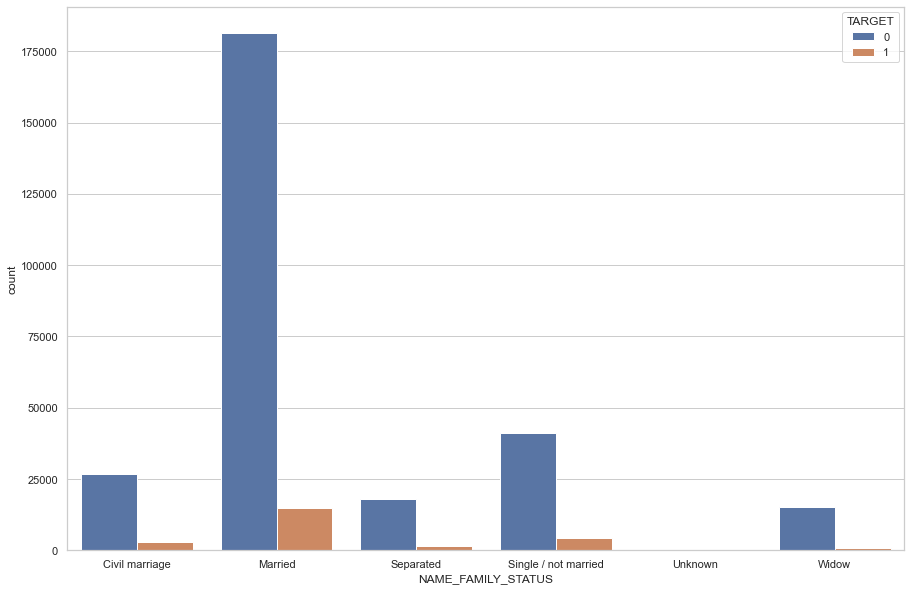

In [81]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='NAME_FAMILY_STATUS', hue="TARGET", data=appTrainC)

In [82]:
familyStatus = pd.crosstab(appTrainC['NAME_FAMILY_STATUS'], appTrainC['TARGET'], margins = True)

In [83]:
familyStatus

TARGET,0,1,All
NAME_FAMILY_STATUS,,,
Civil marriage,26811,2961,29772
Married,181572,14850,196422
Separated,18150,1620,19770
Single / not married,40984,4457,45441
Unknown,2,0,2
Widow,15151,937,16088
All,282670,24825,307495


In [84]:
for i, ind in enumerate(familyStatus.index):
    print(ind)
    print(familyStatus.loc[ind]/familyStatus['All'].values[i])

Civil marriage
TARGET
0      0.900544
1      0.099456
All    1.000000
Name: Civil marriage, dtype: float64
Married
TARGET
0      0.924397
1      0.075603
All    1.000000
Name: Married, dtype: float64
Separated
TARGET
0      0.918058
1      0.081942
All    1.000000
Name: Separated, dtype: float64
Single / not married
TARGET
0      0.901917
1      0.098083
All    1.000000
Name: Single / not married, dtype: float64
Unknown
TARGET
0      1.0
1      0.0
All    1.0
Name: Unknown, dtype: float64
Widow
TARGET
0      0.941758
1      0.058242
All    1.000000
Name: Widow, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les personnes seules sont plus susceptibles de faire un défaut.

In [85]:
appTrainC.groupby(by="TARGET")["REGION_POPULATION_RELATIVE"].mean()

TARGET
0    0.021027
1    0.019135
Name: REGION_POPULATION_RELATIVE, dtype: float16

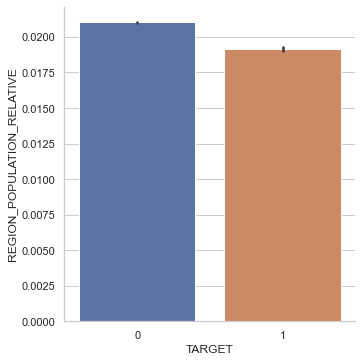

In [86]:
sns.catplot(x="TARGET", y="REGION_POPULATION_RELATIVE",kind="bar", data=appTrainC)

Les profils qui font défaut de paiment vivent dans des lieux moins peuplés.

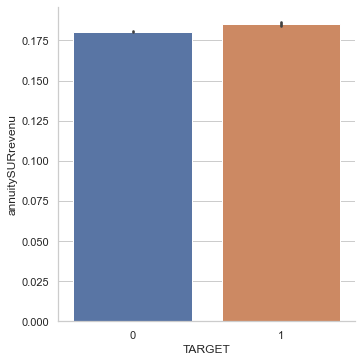

In [87]:
sns.catplot(x="TARGET", y="annuitySURrevenu",kind="bar", data=appTrainC)

Les mensualités pésent davantage sur les profils qui font défaut, mais ce n'est pas significatif.

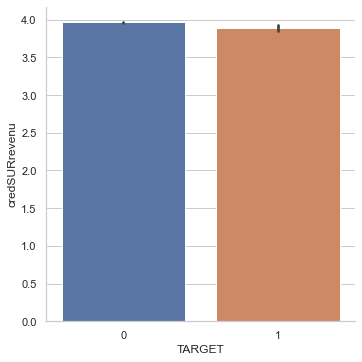

In [88]:
sns.catplot(x="TARGET", y="credSURrevenu",kind="bar", data=appTrainC)

Le poid du crédit sur le revenu total est plus ou moins équivalent sur les deux profils

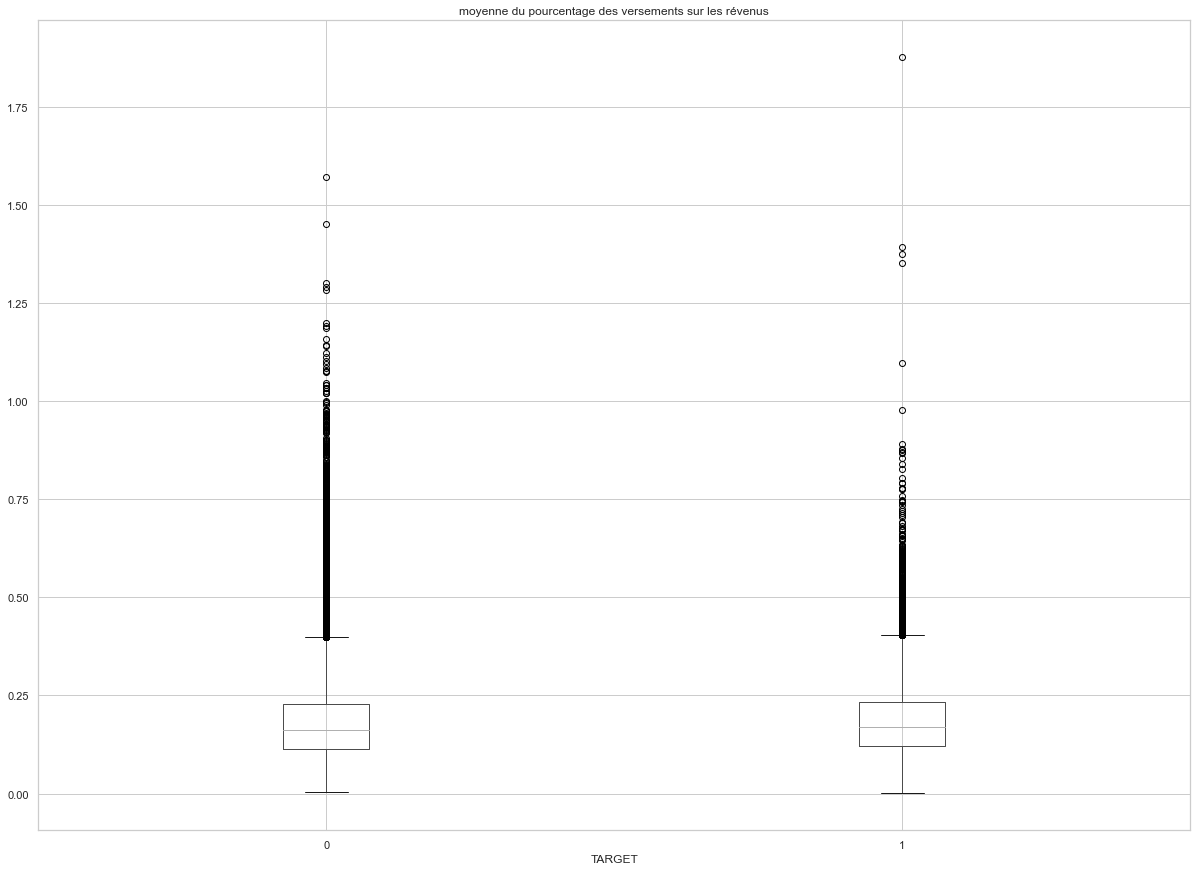

In [89]:
appTrainC.boxplot(column = ['annuitySURrevenu'], by = 'TARGET', figsize=(20,15))
plt.title('moyenne du pourcentage des versements sur les révenus')
plt.suptitle('')
plt.show()

Les deux profils (0 et 1) ont plus ou moins la même distribution avec un extremum chez 1, avec une mensualité qui pèse presque 2 fois ses revenus

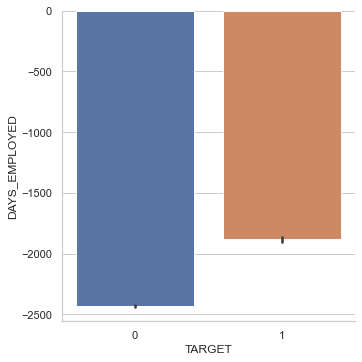

In [90]:
sns.catplot(x="TARGET", y="DAYS_EMPLOYED",kind="bar", data=appTrainC)

Nous constatons qu'il y a correlation entre le nombre de jour de salariat et le défaut de paiment.

In [91]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean()

TARGET
0    2.150391
1    2.181641
Name: CNT_FAM_MEMBERS, dtype: float16

<AxesSubplot:xlabel='TARGET'>

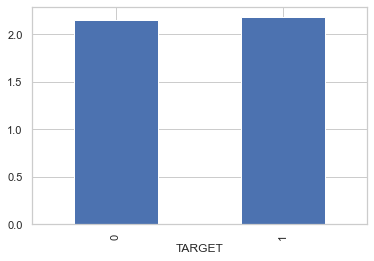

In [92]:
appTrainC.groupby(by="TARGET")["CNT_FAM_MEMBERS"].mean().plot.bar()

La taille des familles des deux profils est plus ou moins équivalente

In [93]:
house = pd.crosstab(appTrainC['NAME_HOUSING_TYPE'], appTrainC['TARGET'], margins = True)

In [94]:
house

TARGET,0,1,All
NAME_HOUSING_TYPE,,,
Co-op apartment,1033,89,1122
House / apartment,251583,21272,272855
Municipal apartment,10226,955,11181
Office apartment,2445,172,2617
Rented apartment,4279,601,4880
With parents,13104,1736,14840
All,282670,24825,307495


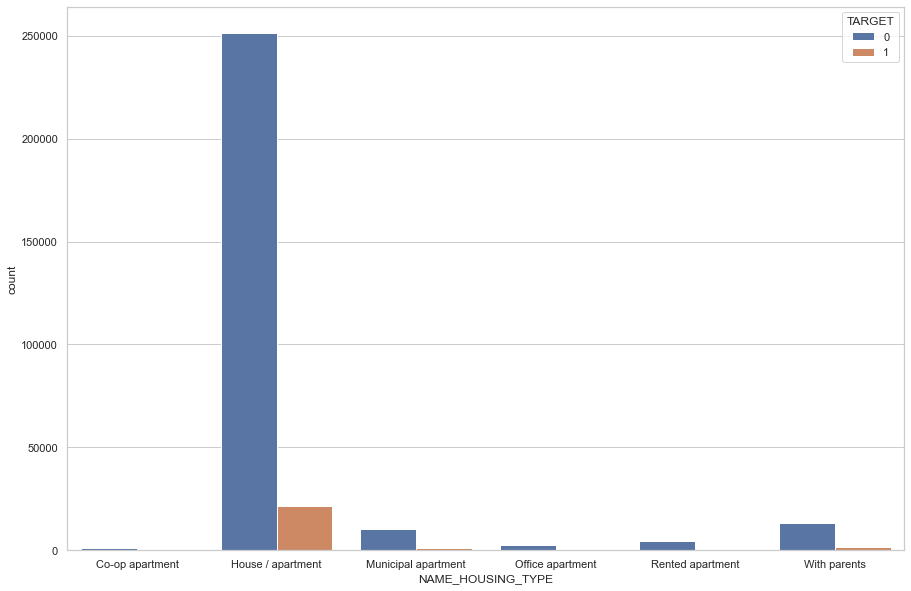

In [95]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="NAME_HOUSING_TYPE", hue="TARGET", data=appTrainC)

In [96]:
for i, ind in enumerate(house.index):
    print(ind)
    print(house.loc[ind]/house['All'].values[i])

Co-op apartment
TARGET
0      0.920677
1      0.079323
All    1.000000
Name: Co-op apartment, dtype: float64
House / apartment
TARGET
0      0.922039
1      0.077961
All    1.000000
Name: House / apartment, dtype: float64
Municipal apartment
TARGET
0      0.914587
1      0.085413
All    1.000000
Name: Municipal apartment, dtype: float64
Office apartment
TARGET
0      0.934276
1      0.065724
All    1.000000
Name: Office apartment, dtype: float64
Rented apartment
TARGET
0      0.876844
1      0.123156
All    1.000000
Name: Rented apartment, dtype: float64
With parents
TARGET
0      0.883019
1      0.116981
All    1.000000
Name: With parents, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


Les profils qui louent des appartements ont plus de chance de faire défaut.

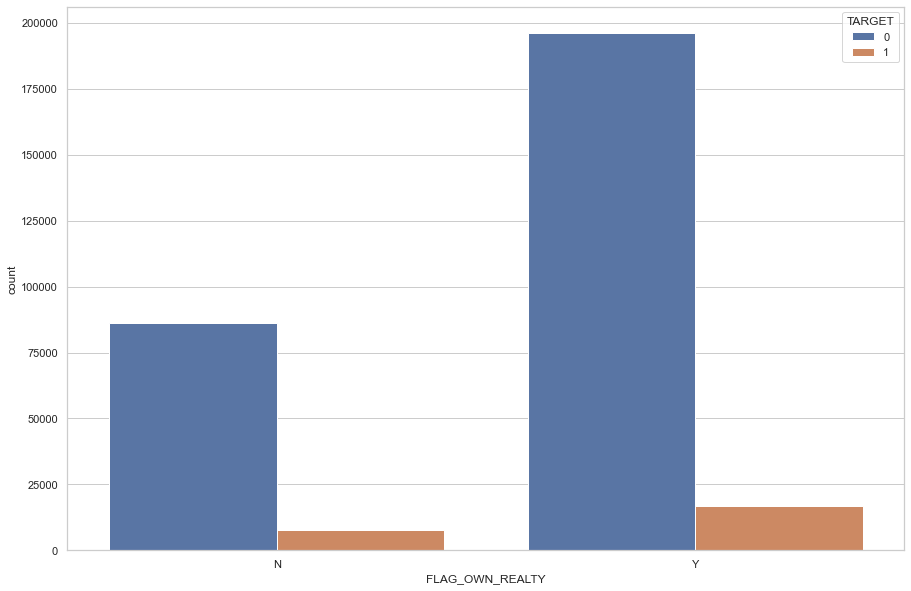

In [97]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="FLAG_OWN_REALTY", hue="TARGET", data=appTrainC)

In [98]:
test = pd.crosstab(appTrainC["FLAG_OWN_REALTY"], appTrainC['TARGET'], margins = True)
test

TARGET,0,1,All
FLAG_OWN_REALTY,,,
N,86348,7842,94190
Y,196322,16983,213305
All,282670,24825,307495


In [99]:
for i, ind in enumerate(test.index):
    print(ind)
    print(test.loc[ind]/test['All'].values[i])

N
TARGET
0      0.916743
1      0.083257
All    1.000000
Name: N, dtype: float64
Y
TARGET
0      0.920382
1      0.079618
All    1.000000
Name: Y, dtype: float64
All
TARGET
0      0.919267
1      0.080733
All    1.000000
Name: All, dtype: float64


La possession d'un habitat n'influe pas sur le défaut

# Analyse bivariée

In [100]:
appTrainC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   SK_ID_CURR                  307495 non-null  int32   
 1   TARGET                      307495 non-null  int8    
 2   NAME_CONTRACT_TYPE          307495 non-null  category
 3   CODE_GENDER                 307495 non-null  object  
 4   FLAG_OWN_CAR                307495 non-null  category
 5   FLAG_OWN_REALTY             307495 non-null  category
 6   CNT_CHILDREN                307495 non-null  int8    
 7   AMT_INCOME_TOTAL            307495 non-null  float32 
 8   AMT_CREDIT                  307495 non-null  float32 
 9   AMT_ANNUITY                 307495 non-null  float32 
 10  AMT_GOODS_PRICE             307495 non-null  float32 
 11  NAME_INCOME_TYPE            307495 non-null  category
 12  NAME_EDUCATION_TYPE         307495 non-null  category
 13 

In [101]:
Description("FLAG_OWN_REALTY")

['Flag if client owns a house or flat']
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']


5    Flag if client owns a house or flat
Name: Description, dtype: category
Categories (163, object): ['Age of client's car', 'Amount drawing at ATM during the month of the..., 'Amount drawing during the month of the previo..., 'Amount drawing or buying goods during the mon..., ..., 'When was the installments of previous credit ..., 'Who accompanied client when applying for the ..., 'Who was accompanying client when he was apply..., 'Why was the previous application rejected']

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_CREDIT'>

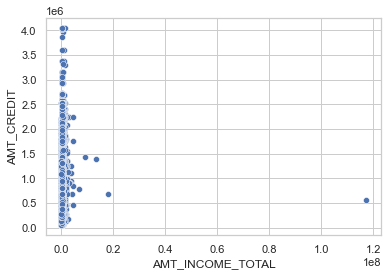

In [102]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_CREDIT', data=appTrainC)

La quantité de crédit n'a pas l'air d'être corrolé avec les revenus. Au contraire les hauts revenus demandent des crédits faibles.

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_ANNUITY'>

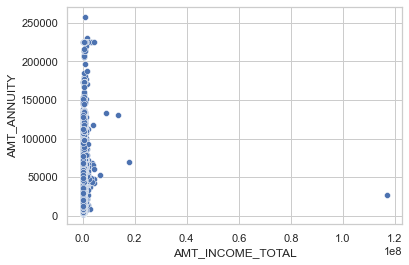

In [103]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'AMT_ANNUITY', data=appTrainC)

Les mensualités n'ont pas l'air d'être corrolé avec les revenus.

<AxesSubplot:xlabel='EXT_SOURCE_2', ylabel='AMT_ANNUITY'>

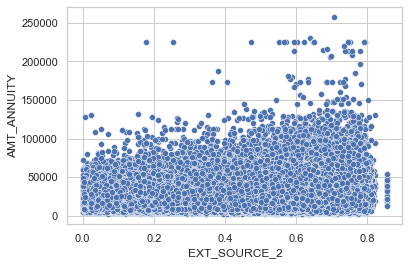

In [104]:
sns.scatterplot(x='EXT_SOURCE_2', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='EXT_SOURCE_3', ylabel='AMT_ANNUITY'>

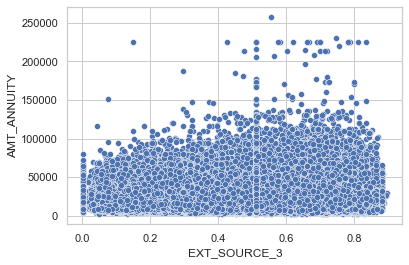

In [105]:
sns.scatterplot(x='EXT_SOURCE_3', y = 'AMT_ANNUITY', data=appTrainC)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='REGION_POPULATION_RELATIVE'>

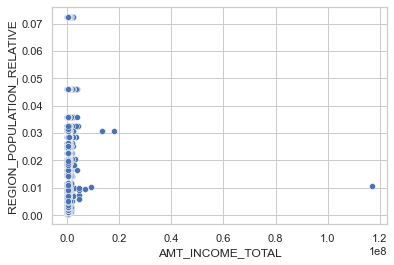

In [106]:
sns.scatterplot(x='AMT_INCOME_TOTAL', y = 'REGION_POPULATION_RELATIVE', data=appTrainC)

# Corrélation

In [107]:
# bureau

In [108]:
# homeCredit

In [109]:
# previous_Apps

In [110]:
correlation = appTrainC.drop(['SK_ID_CURR', 'TARGET'], axis=1)

In [111]:
correlation = correlation.select_dtypes(exclude=['object', 'category', 'int8'])

In [112]:
correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307495 entries, 0 to 307510
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            307495 non-null  float32
 1   AMT_CREDIT                  307495 non-null  float32
 2   AMT_ANNUITY                 307495 non-null  float32
 3   AMT_GOODS_PRICE             307495 non-null  float32
 4   REGION_POPULATION_RELATIVE  307495 non-null  float16
 5   DAYS_BIRTH                  307495 non-null  int16  
 6   DAYS_EMPLOYED               307495 non-null  float64
 7   CNT_FAM_MEMBERS             307495 non-null  float16
 8   EXT_SOURCE_2                307495 non-null  float16
 9   EXT_SOURCE_3                307495 non-null  float16
 10  credSURrevenu               307495 non-null  float32
 11  annuitySURrevenu            307495 non-null  float32
dtypes: float16(4), float32(6), float64(1), int16(1)
memory usage: 22.7 MB


<AxesSubplot:>

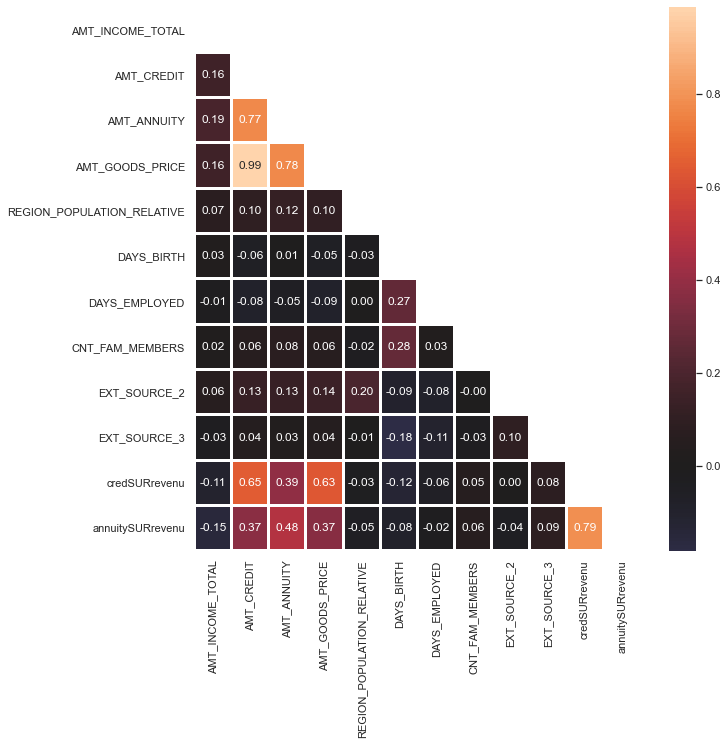

In [113]:
corr = correlation.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr, center=0, linewidths=2, mask=mask, annot=True, fmt=".2f")

AMT_GOODS_PRICE et AMT_CREDIT sont très fortement corrolés. Nous supprimerons l'un des deux par la suite.

In [114]:
#appTrainC.to_csv('app/Train.csv', index=False)

# Aggregation des données

## Bureau

In [ ]:
bureau = reduce_mem_usage(pd.read_csv("zip/bureau.csv")) 

In [115]:
# bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
# bureau_agg.head()

In [116]:
#bureauBal.head()

In [117]:
aggStat =  ['count', 'mean', 'max', 'min', 'sum']
aggStatM = ['count', 'mean', 'median', 'max', 'min', 'sum']

In [118]:
#bureauBal_agg=aggregation(bureauBal, ['SK_ID_BUREAU'], 'SK_ID_BUREAU', 'bureauBal', ['count', 'mean', 'max', 'min', 'sum'])

In [119]:
#bureauBal_agg

In [120]:
# bureau = bureau.merge(bureauBal_agg, on = 'SK_ID_BUREAU', how = 'left')

In [121]:
# bureau = bureau[bureau["SK_ID_CURR"].notna()]

In [122]:
#bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,9.132300e+04,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,2.250000e+05,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,4.643235e+05,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,9.000000e+04,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2.700000e+06,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,1.125000e+04,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2432.0,-2492.0,5476.5,0,3.813084e+04,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,1.557000e+04,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,3.600000e+04,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [123]:
# modelisation = bureau.drop(['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1)
# model_num = modelisation.select_dtypes(exclude=['object', 'category'])
# model_cat = modelisation.select_dtypes(include=['object', 'category'])
# model_onhot = pd.get_dummies(model_cat, drop_first=True)
# bureau_agg = pd.concat([bureau["SK_ID_CURR"],model_num, model_onhot], axis=1)
# bureau_agg = bureau_agg.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()


In [124]:
bureau = reduce_mem_usage(aggregation(bureau, ['SK_ID_CURR', 'SK_ID_BUREAU'], 'SK_ID_CURR', 'bureau'))

Taille du Dataframe avant traitement 248.77 MB
Taille du Dataframe après traitement: 126.28 MB
Réduction de 49.2%


In [125]:
supprimer = extraireColonneInf(bureau,0.8)
bureau.drop(supprimer, axis=1, inplace=True)

Nous agrégeons les données selon 5 modalités statistiques 'count', 'mean', 'max', 'min', 'sum'

sauvegarde des données sur le disque

In [126]:
appTrainC.shape

(307495, 50)

In [127]:
bureau["SK_ID_CURR"].shape

(305811,)

In [128]:
appTrainC_agg = appTrainC.merge(bureau, on = 'SK_ID_CURR', how = 'left')

In [129]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)
appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [130]:
appTrainC_agg=appTrainC_agg[appTrainC_agg["TARGET"].notna()]

In [131]:
appTrainC_agg["TARGET"].value_counts(normalize=True)

0    0.919267
1    0.080733
Name: TARGET, dtype: float64

In [132]:
#appTrainC = appTrainC[appTrainC["TARGET"].notna()]

In [133]:
appTrainC["TARGET"].value_counts()

0    282670
1     24825
Name: TARGET, dtype: int64

# Autre aggregat

In [134]:

# appTrain = reduce_mem_usage(appTrain)
# bureau = reduce_mem_usage(bureau) 
# bureauBal = reduce_mem_usage(bureauBal) 
# creditCardBal = reduce_mem_usage(creditCardBal) 
# homeCredit = reduce_mem_usage(homeCredit) 
# installmentsP = reduce_mem_usage(installmentsP) 
# POS_CASH_B = reduce_mem_usage(POS_CASH_B) 
# previous_Apps = reduce_mem_usage(previous_Apps) 
# sample_sub = reduce_mem_usage(sample_sub) 

In [135]:
POS_CASH_B

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [136]:
installmentsP = reduce_mem_usage(aggregation(installmentsP,["SK_ID_PREV","SK_ID_CURR"], "SK_ID_CURR", "install"))
supprimer = extraireColonneInf(installmentsP,0.8)
installmentsP.drop(supprimer, axis=1, inplace=True)

Taille du Dataframe avant traitement 49.87 MB
Taille du Dataframe après traitement: 34.65 MB
Réduction de 30.5%


In [137]:
appTrainC_agg = appTrainC_agg.merge(installmentsP, on = 'SK_ID_CURR', how = 'left')

In [138]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)
appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [139]:
appTrainC_agg=appTrainC_agg[appTrainC_agg["TARGET"].notna()]

In [140]:
appTrainC_agg

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_median,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_median,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_median,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_median,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_median,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_median,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_median,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_median,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_sum,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Bad debt_median,bureau_CREDIT_ACTIVE_Bad debt_max,bureau_CREDIT_ACTIVE_Bad debt_min,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Closed_median,bureau_CREDIT_ACTIVE_Closed_max,bureau_CREDIT_ACTIVE_Closed_min,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_mean,bureau_CREDIT_ACTIVE_Sold_median,bureau_CREDIT_ACTIVE_Sold_max,bureau_CREDIT_ACTIVE_Sold_min,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 2_median,bureau_CREDIT_CURRENCY_currency 2_max,bureau_CREDIT_CURRENCY_currency 2_min,bureau_CREDIT_CURRENCY_currency 2_sum,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_mean,bureau_CREDIT_CURRENCY_currency 3_median,bureau_CREDIT_CURRENCY_currency 3_max,bureau_CREDIT_CURRENCY_currency 3_min,bureau_CREDIT_CURRENCY_currency 3_sum,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_mean,bureau_CREDIT_CURRENCY_currency 4_median,bureau_CREDIT_CURRENCY_currency 4_max,bureau_CREDIT_CURRENCY_currency 4_min,bureau_CREDIT_CURRENCY_currency 4_sum,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_median,bureau_CREDIT_TYPE_Car loan_max,bureau_CREDIT_TYPE_Car loan_min,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Cash lo

In [141]:
creditCardBal

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.000000,1800.0000,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.000000,2250.0000,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.000000,2250.0000,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.000000,11925.0000,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.000000,27000.0000,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000000,45000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0000,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000000,45000,0.0,0.0,0.0,0.0,0.000000,1879.109985,0.0000,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.968750,585000,270000.0,270000.0,0.0,0.0,2250.000000,375750.000000,356994.6875,269356.125000,273093.968750,273093.968750,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000000,450000,NaN,0.0,NaN,NaN,0.000000,NaN,0.0000,0.000000,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0


In [142]:
creditCardBal = reduce_mem_usage(aggregation(creditCardBal, ['SK_ID_PREV','SK_ID_CURR'], 'SK_ID_CURR', 'creditCB'))
supprimer = extraireColonneInf(creditCardBal,0.8)
creditCardBal.drop(supprimer, axis=1, inplace=True)

Taille du Dataframe avant traitement 68.14 MB
Taille du Dataframe après traitement: 42.57 MB
Réduction de 37.5%


In [143]:
appTrainC_agg = appTrainC_agg.merge(creditCardBal, on = 'SK_ID_CURR', how = 'left')

In [144]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)
appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [145]:
appTrainC_agg=appTrainC_agg[appTrainC_agg["TARGET"].notna()]

In [146]:
#appTrainC = appTrainC[appTrainC["TARGET"].notna()]

In [147]:
appTrainC_agg["TARGET"].value_counts(normalize=True)

0    0.919267
1    0.080733
Name: TARGET, dtype: float64

In [148]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)

In [149]:
len(supprimer)

0

In [150]:
#appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [151]:
previous_Apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int32   
 1   SK_ID_CURR                   1670214 non-null  int32   
 2   NAME_CONTRACT_TYPE           1670214 non-null  category
 3   AMT_ANNUITY                  1297979 non-null  float32 
 4   AMT_APPLICATION              1670214 non-null  float32 
 5   AMT_CREDIT                   1670213 non-null  float32 
 6   AMT_DOWN_PAYMENT             774370 non-null   float32 
 7   AMT_GOODS_PRICE              1284699 non-null  float32 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  category
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8    
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  category
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8    
 12  RATE_DOWN_PAYMENT           

In [152]:
previous_Apps = reduce_mem_usage(aggregation(previous_Apps, ['SK_ID_PREV','SK_ID_CURR'], 'SK_ID_CURR', 'prevApps'))

Taille du Dataframe avant traitement 1264.20 MB
Taille du Dataframe après traitement: 554.86 MB
Réduction de 56.1%


In [153]:
supprimer = extraireColonneInf(previous_Apps,0.8)
previous_Apps.drop(supprimer, axis=1, inplace=True)

In [154]:
appTrainC_agg = appTrainC_agg.merge(previous_Apps, on = 'SK_ID_CURR', how = 'left')

In [155]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)
appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [158]:
POS_CASH_B = reduce_mem_usage(aggregation(POS_CASH_B, ['SK_ID_PREV','SK_ID_CURR'], 'SK_ID_CURR', 'POS'))

Taille du Dataframe avant traitement 110.96 MB
Taille du Dataframe après traitement: 52.10 MB
Réduction de 53.0%


In [159]:
supprimer = extraireColonneInf(POS_CASH_B,0.8)
POS_CASH_B.drop(supprimer, axis=1, inplace=True)

In [160]:
appTrainC_agg = appTrainC_agg.merge(POS_CASH_B, on = 'SK_ID_CURR', how = 'left')

In [161]:
supprimer = extraireColonneInf(appTrainC_agg,0.8)
appTrainC_agg.drop(supprimer, axis=1, inplace=True)

In [162]:
#appTrainC_agg.to_csv('appTrainC_agg.csv', index=False)

In [183]:
del appTrain
del appTrainC
del bureau
del bureauBal
del creditCardBal
del homeCredit
del installmentsP 
del POS_CASH_B
del previous_Apps 
del sample_sub

# Modélisation (Classification)

In [ ]:
modelisation = appTrainC.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)

In [ ]:
#modelisation

In [ ]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

Nous segmentons les données en deux : les features numériques et les features catégorielles

In [ ]:
# model_cat

In [ ]:
# modelisation.info()

In [ ]:
# modelisation['DAYS_EMPLOYED'].min()

In [ ]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [ ]:
model_onhot.shape

Nous encodons les valeurs catégorielles en valeur numérique

In [ ]:
model = pd.concat([model_num, model_onhot], axis=1)

In [ ]:
model

In [ ]:
del modelisation
del model_num
del model_cat
del model_onhot


## Pycaret

In [ ]:
modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [ ]:
modelS

In [ ]:
clf1 = setup(data = modelS, target = 'TARGET')

In [ ]:
#best_model = compare_models(sort = 'AUC')

Selon les modèles, nous pouvons maximiser différents scores. Mais il n'existe pas un modèle qui maximise le recall et la precision.

In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 3, sort = 'AUC')

## Recentrons les données

Nous allons réutiliser les mêmes algorithmes mais cette fois sur des données recentrées

In [ ]:
# scaler = StandardScaler()
# scaler.fit(model_num)
# model_scale = scaler.transform(model_num)

In [ ]:
# model = pd.concat([pd.DataFrame(model_scale).reset_index(), model_onhot.reset_index()], axis=1)

In [ ]:
# model_scale.shape

In [ ]:
# model_onhot.shape

In [ ]:
# model

In [ ]:
# model.drop(['index'], axis=1, inplace=True)

In [ ]:
# model.shape

In [ ]:
# modelS = pd.concat([model, appTrainC['TARGET']], axis=1)

In [ ]:
# clf1 = setup(data = modelS, target = 'TARGET')

In [ ]:
# best_model = compare_models()

## resamplons les datas

In [ ]:
count_nondefault, count_default = modelS['TARGET'].value_counts()

In [ ]:
count_default

In [ ]:
count_nondefault

In [ ]:
nondefaults = modelS[modelS['TARGET'] == 0]
defaults = modelS[modelS['TARGET'] == 1]

In [ ]:
nondefaults_under = nondefaults.sample(count_default)

In [ ]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [ ]:
clf1 = setup(data = X_y_train_under, target = 'TARGET')

In [ ]:
best_model = compare_models()

In [ ]:
ensembled_models = compare_models(models(type='ensemble').index.tolist(), fold = 10)

L'algorithme __lightgbm__ est un bon compromis entre les scores Accuracy, AUC, Recall, Prec

# Light Gradient Boosting Machine

In [9]:
# %reset -f

In [8]:
appTrainC_agg = reduce_mem_usage(pd.read_csv("trainnotNa.csv"))

Taille du Dataframe avant traitement 2083.30 MB
Taille du Dataframe après traitement: 556.83 MB
Réduction de 73.3%


In [9]:
modelisation = appTrainC_agg.drop(['SK_ID_CURR', 'TARGET', 'AMT_GOODS_PRICE'], axis=1)

In [10]:
model_num = modelisation.select_dtypes(exclude=['object', 'category'])
model_cat = modelisation.select_dtypes(include=['object', 'category'])

In [11]:
model_onhot = pd.get_dummies(model_cat, drop_first=True)

In [12]:
model = pd.concat([model_num, model_onhot], axis=1)

In [13]:
X = model
y = appTrainC_agg['TARGET']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [15]:
target_names = ['Non-Default', 'Default']

In [16]:
del modelisation
del model_num
del model_cat
del model_onhot
#del X
#del y
del appTrainC_agg

Nous divisons les données en deux. Un training set et test set

In [19]:
lgbm = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 42)

In [20]:
#display(X_train)

In [21]:
clf = lgbm.fit(X_train.to_numpy(), y_train)

In [22]:
preds = clf.predict(X_test)

In [23]:

print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96     41741
     Default       0.41      0.11      0.17      3468

    accuracy                           0.92     45209
   macro avg       0.67      0.55      0.57     45209
weighted avg       0.89      0.92      0.90     45209



In [24]:
print(metrics.roc_auc_score(y_test, preds))

0.5483185920193807


# Resamplons les données

In [17]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)

In [18]:
count_nondefault, count_default = X_y_train['TARGET'].value_counts()

In [19]:
nondefaults = X_y_train[X_y_train['TARGET'] == 0]
defaults = X_y_train[X_y_train['TARGET'] == 1]

In [20]:
nondefaults_under = nondefaults.sample(count_default)

In [21]:
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [22]:
print(X_y_train_under['TARGET'].value_counts())

0    13873
1    13873
Name: TARGET, dtype: int64


In [23]:
X = X_y_train_under.drop('TARGET', axis=1)
y = X_y_train_under['TARGET']

In [29]:
X

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,credSURrevenu,annuitySURrevenu,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_median,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_median,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_median,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_median,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_median,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_median,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_median,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_median,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_sum,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Bad debt_median,bureau_CREDIT_ACTIVE_Bad debt_max,bureau_CREDIT_ACTIVE_Bad debt_min,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_ACTIVE_Closed_median,bureau_CREDIT_ACTIVE_Closed_max,bureau_CREDIT_ACTIVE_Closed_min,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_mean,bureau_CREDIT_ACTIVE_Sold_median,bureau_CREDIT_ACTIVE_Sold_max,bureau_CREDIT_ACTIVE_Sold_min,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 2_median,bureau_CREDIT_CURRENCY_currency 2_max,bureau_CREDIT_CURRENCY_currency 2_min,bureau_CREDIT_CURRENCY_currency 2_sum,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_mean,bureau_CREDIT_CURRENCY_currency 3_median,bureau_CREDIT_CURRENCY_currency 3_max,bureau_CREDIT_CURRENCY_currency 3_min,bureau_CREDIT_CURRENCY_currency 3_sum,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_mean,bureau_CREDIT_CURRENCY_currency 4_median,bureau_CREDIT_CURRENCY_currency 4_max,bureau_CREDIT_CURRENCY_currency 4_min,bureau_CREDIT_CURRENCY_currency 4_sum,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_median,bureau_CREDIT_TYPE_Car loan_max,bureau_CREDIT_TYPE_Car loan_min,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_median,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_max,bureau_CRE

In [40]:
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [41]:
clfL = lgb.LGBMClassifier(n_jobs = -1, random_state = 42).fit(X.to_numpy(), y, feature_name=list(X.columns))

In [42]:
preds = clfL.predict(X_test)

In [43]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.96      0.71      0.82     41741
     Default       0.16      0.69      0.26      3468

    accuracy                           0.71     45209
   macro avg       0.56      0.70      0.54     45209
weighted avg       0.90      0.71      0.77     45209



In [36]:
predTrains = clfL.predict(X_train)

In [37]:
print(classification_report(y_train, predTrains, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.98      0.71      0.82    166963
     Default       0.18      0.79      0.30     13873

    accuracy                           0.72    180836
   macro avg       0.58      0.75      0.56    180836
weighted avg       0.91      0.72      0.78    180836



Ce qui nous intéresse surtout est de minimiser les faux négatifs. Ces profils coûtent chers à l'entreprise

In [38]:
#pickle.dump(clfL, open('app/clf.pkl', 'wb'))

In [ ]:
#load_clf = pickle.load(open('app/clf.pkl', 'rb'))

In [ ]:
# preds = load_clf.predict(X_test)
# print(classification_report(y_test, preds, target_names=target_names))

In [ ]:
# preds = load_clf.predict(X_train)
# print(classification_report(y_train, preds, target_names=target_names))

In [186]:
print(metrics.confusion_matrix(y_test, preds))

[[39809 16725]
 [ 1510  3455]]


In [187]:
5060/(5060+2388)

0.6793770139634802

In [188]:
print(metrics.roc_auc_score(y_test, preds))

0.7000157129909009


In [189]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test))[1], pd.Series(clfL.predict(X_test)), y_test.reset_index(drop=True), X_test['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [190]:
preds_df

,prob_defaut,PRED_TARGET,TARGET,AMT_CREDIT
0,0.751547,1.0,0.0,226908.0
1,0.113394,0.0,0.0,314055.0
2,0.257076,0.0,0.0,685012.5
3,0.875105,1.0,1.0,376920.0
4,0.648374,1.0,0.0,272520.0
...,...,...,...,...
61494,0.360549,0.0,0.0,1473444.0
61495,0.796048,1.0,0.0,348264.0
61496,0.178039,0.0,0.0,1125000.0
61497,0.846923,1.0,1.0,360000.0


In [191]:
#print(classification_report(preds_df['TARGET'], preds_df['PRED_TARGET'], target_names=target_names))

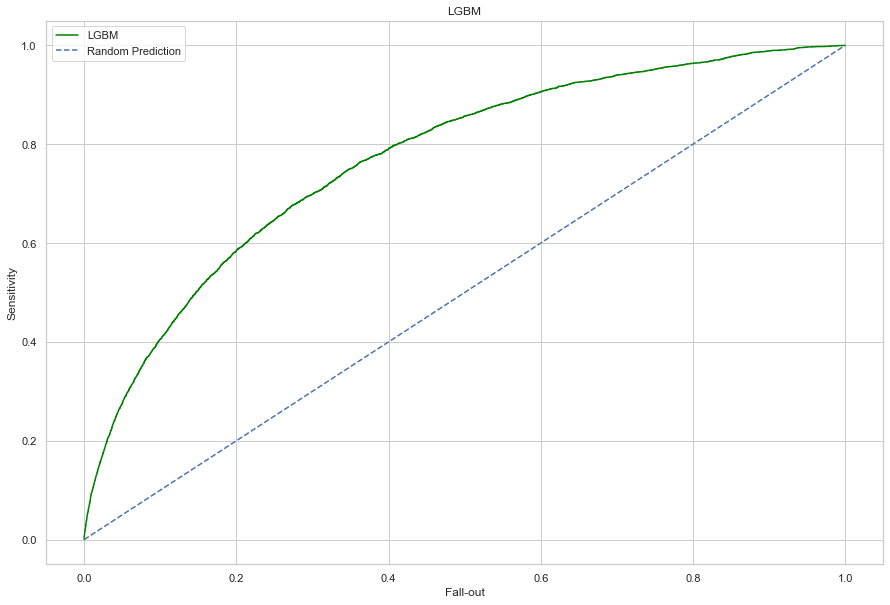

In [192]:
fallout_gbt, sensitivity_gbt, thresholds_gbt = metrics.roc_curve(y_test, preds_df["prob_defaut"])

plt.figure(figsize=(15,10))
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'LGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("LGBM")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [261]:
results.iloc[-20:-1]

,Features,Importances
315,prevApps_CNT_PAYMENT_mean,0.833333
999,prevApps_NAME_YIELD_GROUP_high_mean,0.900000
567,prevApps_NAME_CONTRACT_STATUS_Refused_mean,0.900000
4,REGION_POPULATION_RELATIVE,0.933333
37,annuitySURrevenu,0.966667
249,install_AMT_PAYMENT_sum,1.100000
73,bureau_AMT_CREDIT_SUM_DEBT_mean,1.133333
246,install_AMT_PAYMENT_median,1.200000
1197,CODE_GENDER_M,1.300000
1131,POS_CNT_INSTALMENT_FUTURE_mean,1.333333


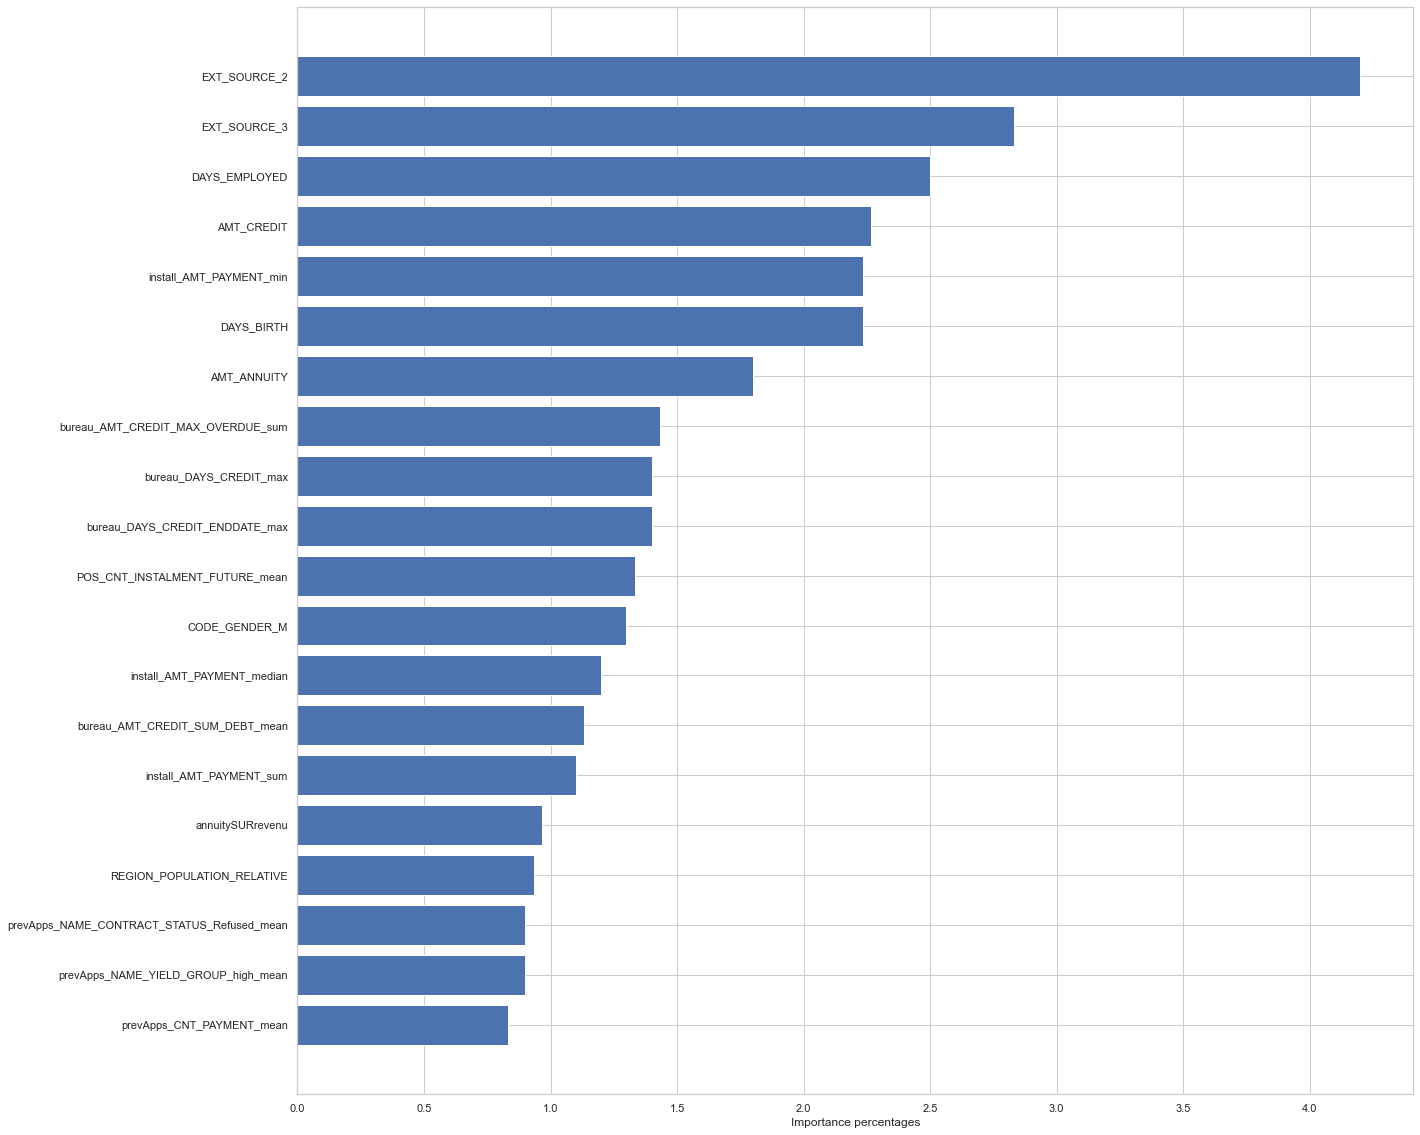

In [263]:
feature_importances = (clfL.feature_importances_/ sum(clfL.feature_importances_)) * 100

results = pd.DataFrame({'Features': X_test.columns,
                        'Importances': feature_importances})
results.sort_values(by='Importances', inplace=True)
resultsReduce = results.iloc[-20:]

plt.figure(figsize=(20,20))

ax = plt.barh(resultsReduce['Features'], resultsReduce['Importances'])
plt.xlabel('Importance percentages')
plt.show()

<AxesSubplot:>

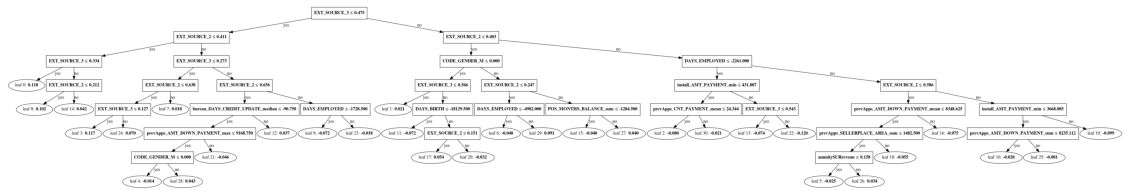

In [44]:

#lgb.plot_tree(clfL, tree_index=0, figsize=(20,30), orientation='vertical')

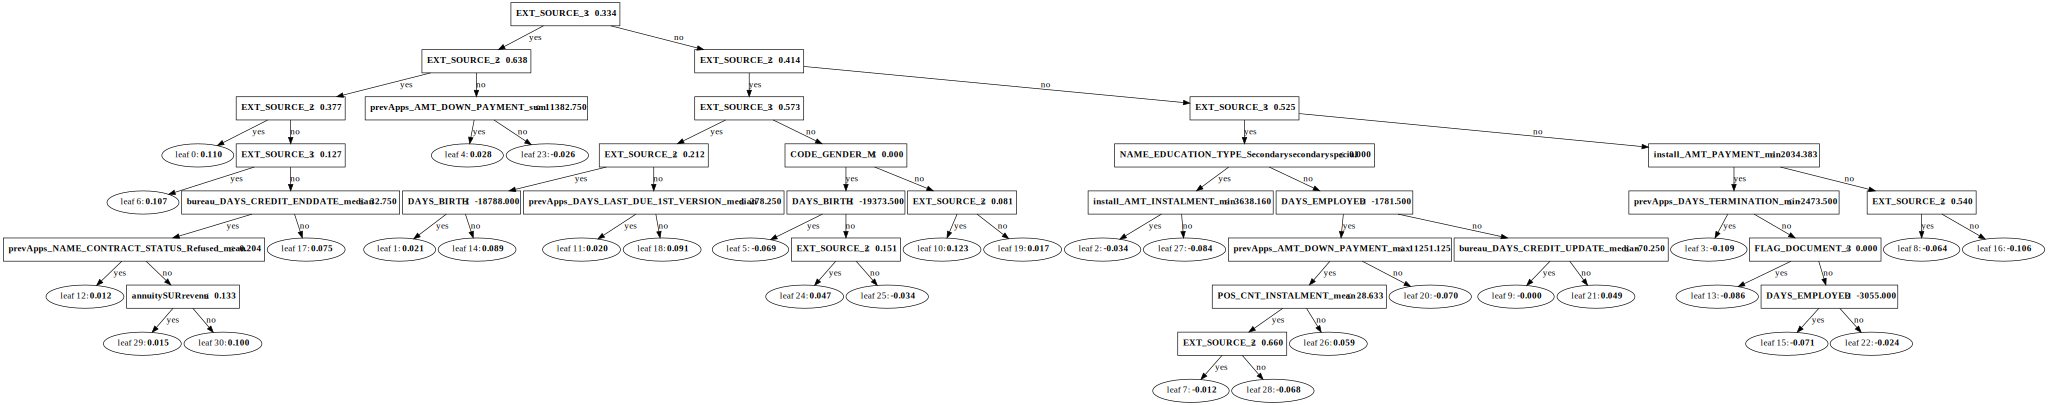

In [45]:
lgb.create_tree_digraph(clfL, tree_index=1, orientation='vertical')

# idéal théorique

In [195]:
thresh = [0.2, 0.225,0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

In [196]:
def_recalls = []
nondef_recalls = []
acc = []

In [197]:
for i in thresh:
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > i else 0)
    acc.append(metrics.accuracy_score(y_test, preds_df['pred_TARGET']))
    def_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][1])
    nondef_recalls.append(metrics.precision_recall_fscore_support(y_test,preds_df['pred_TARGET'])[1][0])

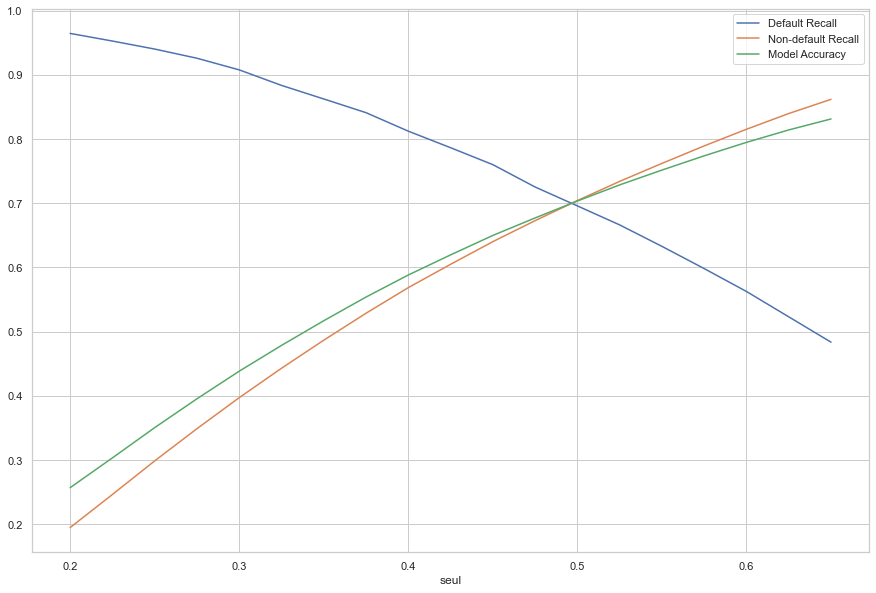

In [198]:
plt.figure(figsize=(15,10))
plt.plot(thresh, def_recalls)
plt.plot(thresh, nondef_recalls)
plt.plot(thresh, acc)
plt.xlabel("seul")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

Ici en un sens le juste milieu entre la capacité du modèle à identifier les vrais défauts, les vrais non-défauts est situé aux alentours d'un seuil de 0.5.<br>
Mais il se peut que du point de vue du métier, ce seuil soit différent.

# Théorie != pratique

Fixons un taux d'acceptation à 85%

In [199]:
threshold_85 = np.quantile(preds_df["prob_defaut"], 0.85)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

0    52274
1     9225
Name: pred_TARGET, dtype: int64


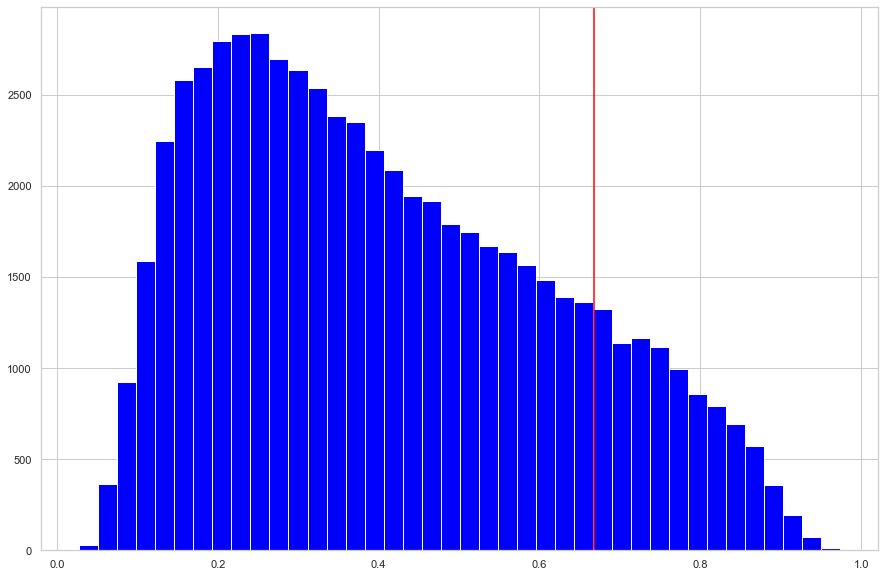

In [200]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold_85, color = 'red')
plt.show()

In [201]:
np.sum(preds_df['TARGET'])

4965.0

In [202]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [203]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

0.05186134598461951


Parmi les profils acceptés avec un taux d'acceptation de 85%. Nous aurons 5% de faux négatifs

## Le coût

In [204]:
avg_loan = np.mean(preds_df['AMT_CREDIT'])

In [205]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                  0                 1
TARGET                                          
$0.00       $29,704,050,549.07 $4,177,853,164.21
$1.00        $1,624,753,970.47 $1,350,865,160.25


Les prévisions de notre modèle permettent de gagner 44 milliards, les FN causent une perte de 2.6 milliards, les FP causent une perte de 6,4 milliards qui est à relativiser dans la mesure où les pertes dûes à un faux positifs relèvent davantage (d'un certain point de vue) des coûts horaires du chargé de clientèle.

# Seuil 0.5

In [206]:
threshold = np.quantile(preds_df["prob_defaut"], 0.5)

# seuil d'acceptation = 0.85
preds_df['pred_TARGET'] = preds_df["prob_defaut"].apply(lambda x: 1 if x > 0.5 else 0)

# Print the counts of loan status after the threshold
print(preds_df['pred_TARGET'].value_counts())

0    41319
1    20180
Name: pred_TARGET, dtype: int64


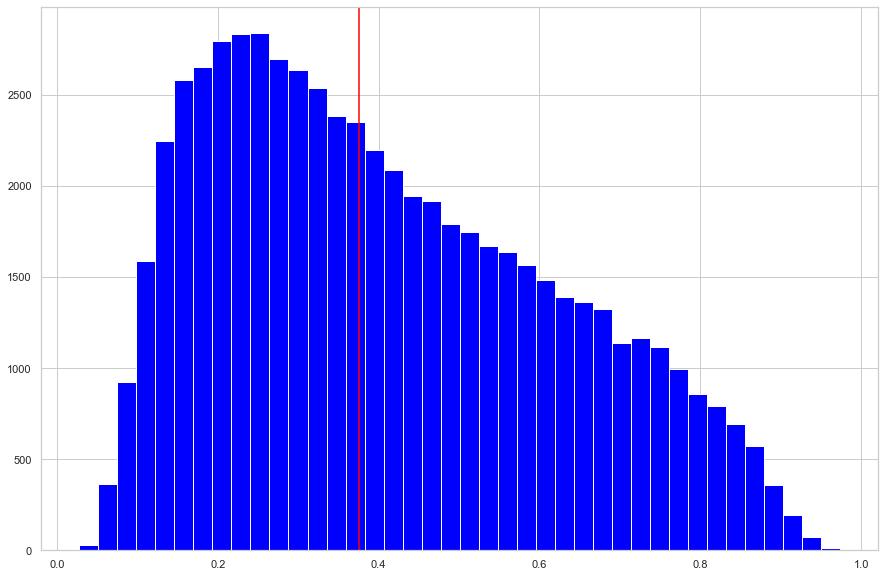

In [207]:
plt.figure(figsize=(15,10))
plt.hist(preds_df["prob_defaut"], color = 'blue', bins = 40)

plt.axvline(x = threshold, color = 'red')
plt.show()

In [208]:
accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]

In [209]:
print(np.sum(accepted_loans['TARGET']) / accepted_loans['TARGET'].count())

0.03654493090345846


In [210]:
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                  0                  1
TARGET                                           
$0.00       $23,858,292,442.10 $10,023,611,271.17
$1.00          $904,971,779.94  $2,070,647,350.79


On peut voir que le taux théorique produit des profits inférieurs à celui que nous avons fixé par hasard, soit le taux de 85%

# Recherche d'un seuil pour un profit maximal

In [211]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

Définissons différent taux d'acceptation.

In [212]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [213]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

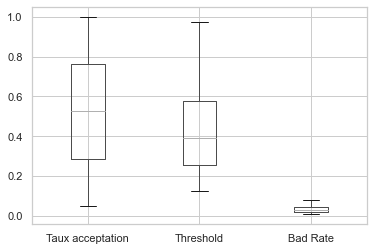

In [214]:
strat_df.boxplot()
plt.show()

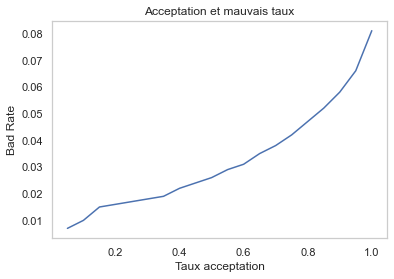

In [215]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [216]:
strat_df['Avg'] = avg_loan

In [217]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))
    

In [218]:
strat_df['nb_accept'] = nb_accept

In [219]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept
0,1.00,0.974,0.081,599319.059562,61499
1,0.95,0.797,0.066,599319.059562,58434
2,0.90,0.727,0.058,599319.059562,55338
3,0.85,0.667,0.052,599319.059562,52255
4,0.80,0.615,0.047,599319.059562,49218
5,0.75,0.567,0.042,599319.059562,46122
6,0.70,0.523,0.038,599319.059562,43007
7,0.65,0.482,0.035,599319.059562,39940
8,0.60,0.444,0.031,599319.059562,36883
9,0.55,0.408,0.029,599319.059562,33793


In [220]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

In [221]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept,estimation
0,1.00,0.974,0.081,599319.059562,61499,3.088660e+10
1,0.95,0.797,0.066,599319.059562,58434,3.039789e+10
2,0.90,0.727,0.058,599319.059562,55338,2.931796e+10
3,0.85,0.667,0.052,599319.059562,52255,2.806041e+10
4,0.80,0.615,0.047,599319.059562,49218,2.672454e+10
5,0.75,0.567,0.042,599319.059562,46122,2.531988e+10
6,0.70,0.523,0.038,599319.059562,43007,2.381602e+10
7,0.65,0.482,0.035,599319.059562,39940,2.226123e+10
8,0.60,0.444,0.031,599319.059562,36883,2.073419e+10
9,0.55,0.408,0.029,599319.059562,33793,1.907813e+10


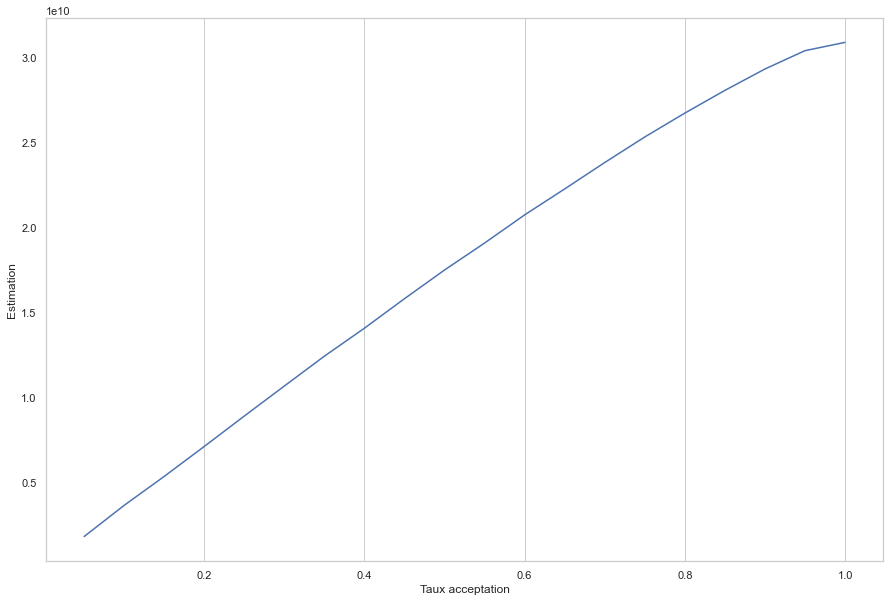

In [222]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

Le dataset ne contient que 8% de profil en défaut. De là, il est normal notre modélisation préconise un taux d'acceptation de 100. Dans tous les cas, nous sommes gagnons.

# Resamplons les données de test

Nous reproduisons le raisonnement précédent mais cette fois en étant moins optimiste vis à vis

In [223]:
X_y_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

In [224]:
X_y_test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
0,0,135000.0,226908.0,10705.5,0.010643,-17832,-4561.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,135000.0,314055.0,16033.5,0.031342,-15569,-8918.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,162000.0,685012.5,26932.5,0.003122,-22943,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,157500.0,376920.0,18261.0,0.025162,-20785,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,112500.0,272520.0,19957.5,0.006306,-10310,-1542.000000,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61494,1,171000.0,1473444.0,46395.0,0.019104,-10359,-345.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
61495,0,158400.0,348264.0,34929.0,0.022797,-14438,-1814.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,0
61496,0,157500.0,1125000.0,33025.5,0.025162,-22402,-2384.175794,1,0,0,...,0,0,0,0,0,0,0,0,1,0
61497,0,112500.0,360000.0,17640.0,0.010963,-14495,-1198.000000,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [225]:
count_nondefault, count_default = X_y_test['TARGET'].value_counts()

In [226]:
nondefaults = X_y_test[X_y_test['TARGET'] == 0]
defaults = X_y_test[X_y_test['TARGET'] == 1]

In [227]:
nondefaults_under = nondefaults.sample(3*count_default, random_state=42)

In [228]:
X_y_test_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

In [229]:
X_test_U = X_y_test_under.drop('TARGET', axis=1)
y_test_U = X_y_test_under['TARGET']

In [230]:
preds = clfL.predict(X_test_U)

In [231]:
print(classification_report(y_test_U, preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.87      0.70      0.78     14895
     Default       0.44      0.70      0.54      4965

    accuracy                           0.70     19860
   macro avg       0.66      0.70      0.66     19860
weighted avg       0.77      0.70      0.72     19860



In [232]:
print(metrics.confusion_matrix(y_test_U, preds))

[[10470  4425]
 [ 1510  3455]]


In [233]:
preds_df = pd.DataFrame(np.array(pd.concat([pd.DataFrame(clfL.predict_proba(X_test_U))[1], pd.Series(clfL.predict(X_test_U)), y_test_U.reset_index(drop=True), X_test_U['AMT_CREDIT'].reset_index(drop=True)], axis=1)), columns=["prob_defaut", "PRED_TARGET","TARGET", "AMT_CREDIT"])

In [234]:
preds_df

,prob_defaut,PRED_TARGET,TARGET,AMT_CREDIT
0,0.448100,0.0,0.0,189621.0
1,0.146597,0.0,0.0,202500.0
2,0.606891,1.0,0.0,834048.0
3,0.292350,0.0,0.0,405000.0
4,0.584590,1.0,0.0,1724220.0
...,...,...,...,...
19855,0.337308,0.0,1.0,314055.0
19856,0.767442,1.0,1.0,582228.0
19857,0.629246,1.0,1.0,247275.0
19858,0.395649,0.0,1.0,315000.0


In [235]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 
                0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

In [236]:
thresholds = []
bad_rates = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    thresholds.append(np.quantile(preds_df['prob_defaut'], rate).round(3))
    
    preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > thresh else 0)
    
    accepted_loans = preds_df[preds_df['pred_TARGET'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['TARGET']) / len(accepted_loans['TARGET'])).round(3))

In [237]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Taux acceptation','Threshold','Bad Rate'])

In [238]:
strat_df

,Taux acceptation,Threshold,Bad Rate
0,1.00,0.974,0.250
1,0.95,0.836,0.225
2,0.90,0.777,0.205
3,0.85,0.725,0.188
4,0.80,0.673,0.174
5,0.75,0.627,0.160
6,0.70,0.583,0.147
7,0.65,0.540,0.136
8,0.60,0.498,0.126
9,0.55,0.458,0.114


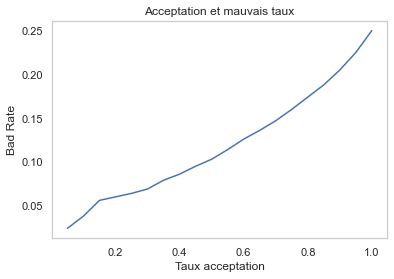

In [239]:
plt.plot(strat_df['Taux acceptation'], strat_df['Bad Rate'])
plt.xlabel('Taux acceptation')
plt.ylabel('Bad Rate')
plt.title('Acceptation et mauvais taux')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [240]:
strat_df['Avg'] = X_test_U["AMT_CREDIT"].mean()

In [241]:
strat_df['Avg'] 

0     591335.4375
1     591335.4375
2     591335.4375
3     591335.4375
4     591335.4375
5     591335.4375
6     591335.4375
7     591335.4375
8     591335.4375
9     591335.4375
10    591335.4375
11    591335.4375
12    591335.4375
13    591335.4375
14    591335.4375
15    591335.4375
16    591335.4375
17    591335.4375
18    591335.4375
19    591335.4375
Name: Avg, dtype: float64

In [242]:
nb_accept = []
for rate in accept_rates:
    
    thresh = np.quantile(preds_df['prob_defaut'], rate).round(3)
    
    nb_accept.append(np.sum(preds_df["prob_defaut"] < thresh))

In [243]:
strat_df['nb_accept'] = nb_accept

In [244]:
strat_df

,Taux acceptation,Threshold,Bad Rate,Avg,nb_accept
0,1.00,0.974,0.250,591335.4375,19860
1,0.95,0.836,0.225,591335.4375,18858
2,0.90,0.777,0.205,591335.4375,17861
3,0.85,0.725,0.188,591335.4375,16881
4,0.80,0.673,0.174,591335.4375,15906
5,0.75,0.627,0.160,591335.4375,14902
6,0.70,0.583,0.147,591335.4375,13910
7,0.65,0.540,0.136,591335.4375,12916
8,0.60,0.498,0.126,591335.4375,11922
9,0.55,0.458,0.114,591335.4375,10929


In [245]:
strat_df['estimation'] = strat_df['nb_accept']*(1-strat_df['Bad Rate'])*strat_df['Avg'] - strat_df['nb_accept']*strat_df['Bad Rate']*strat_df['Avg']

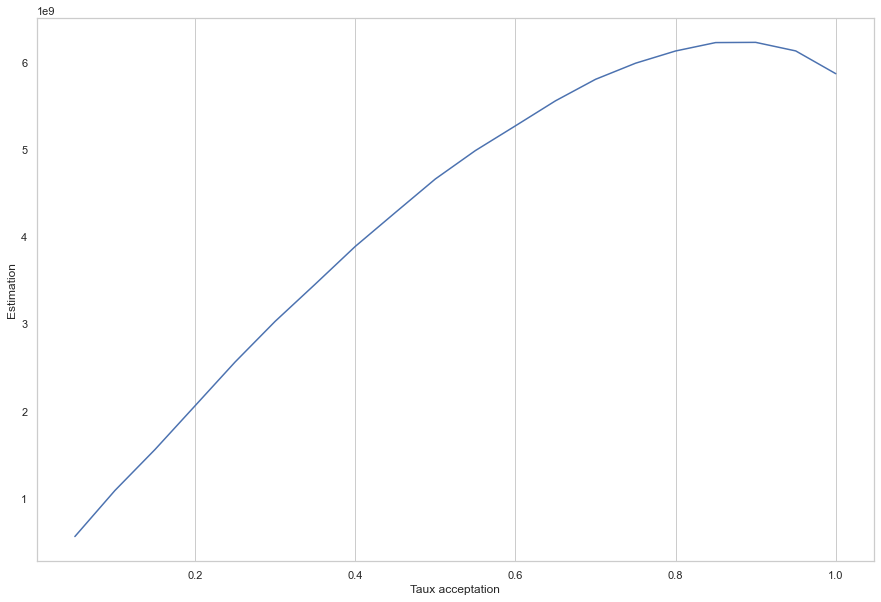

In [246]:
plt.figure(figsize=(15,10))
plt.plot(strat_df['Taux acceptation'], strat_df['estimation'])
plt.title('')
plt.xlabel('Taux acceptation')
plt.ylabel('Estimation')
plt.axes().yaxis.grid()
plt.show()

In [247]:
print(strat_df.loc[strat_df['estimation'] == np.max(strat_df['estimation'])])

   Taux acceptation  Threshold  Bad Rate          Avg  nb_accept    estimation
2               0.9      0.777     0.205  591335.4375      17861  6.231487e+09


Nous avons resamplé le dataset de sorte d'obtenir 25% de défauts dans le dataset. <br>
Dans ce cas, nous fixons le seuil de probabilité de défaut de paiement à 0.777

In [248]:
preds_df['expected_loss'] = preds_df['prob_defaut'] * preds_df['AMT_CREDIT'] 

In [249]:
tot_exp_loss = round(np.sum(preds_df['expected_loss']),2)

In [250]:
print('Le total des pertes attendues: ', '${:,.2f}'.format(tot_exp_loss))

Le total des pertes attendues:  $5,063,961,044.10


In [251]:
preds_df['pred_TARGET'] = preds_df['prob_defaut'].apply(lambda x: 1 if x > 0.752 else 0)
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(preds_df['TARGET'],
                 preds_df['pred_TARGET']).apply(lambda x: x * avg_loan, axis = 0))
pd.reset_option('^display.', silent=True)

pred_TARGET                 0               1
TARGET                                       
$0.00       $8,367,093,390.54 $559,764,001.63
$1.00       $2,058,660,969.60 $916,958,161.13


In [252]:
# %reset -f